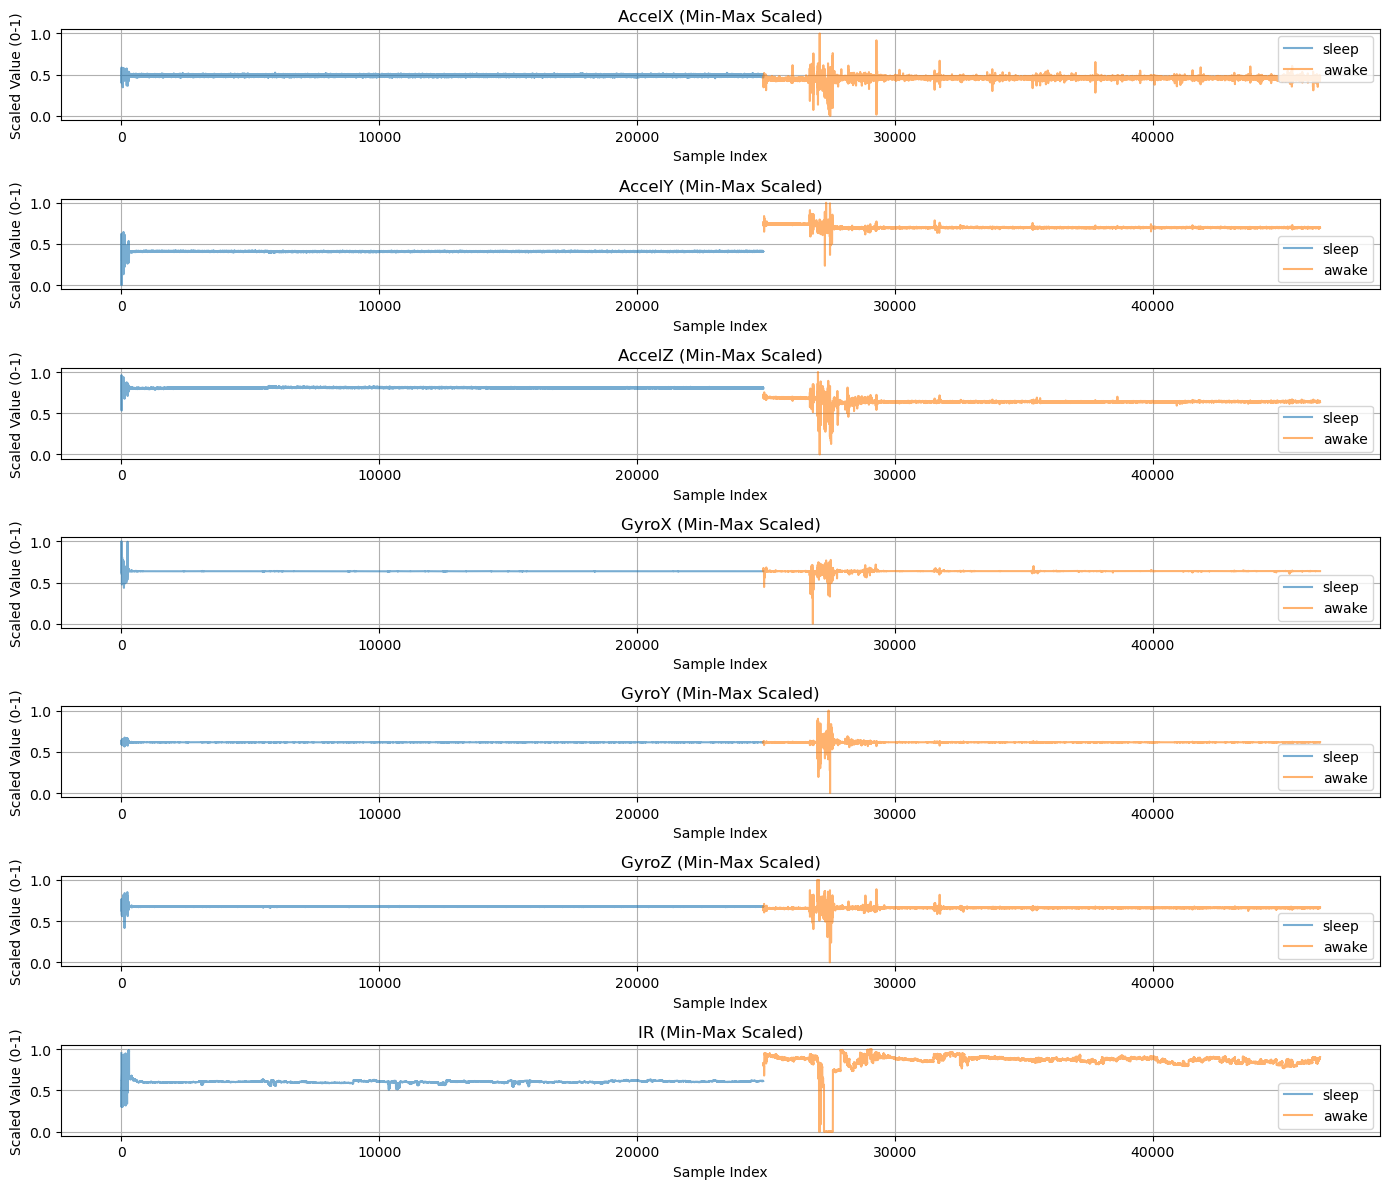

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load merged data
data = pd.read_csv('./aos_data/merged_phuc_data.csv')

# Features to scale and plot
features = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'IR']

# Apply Min-Max scaling to all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled_data, columns=[f"{feat}_Scaled" for feat in features])
data = pd.concat([data, scaled_df], axis=1)

# Create subplots for each feature
plt.figure(figsize=(14, 12))  # Adjust height for 7 subplots

for i, feature in enumerate(features, 1):
    plt.subplot(7, 1, i)  # 7 rows, 1 column
    for label in data['Label'].unique():
        subset = data[data['Label'] == label]
        plt.plot(subset.index, subset[f"{feature}_Scaled"], label=label, alpha=0.6)
    plt.title(f"{feature} (Min-Max Scaled)")
    plt.xlabel("Sample Index")
    plt.ylabel("Scaled Value (0-1)")
    plt.legend()
    plt.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()

Accuracy: 1.00
Number of support vectors: [83 83]
IR_mean: 8.5586
AccelX_std: 4.0544
AccelY_std: -1.9583
AccelZ_std: 3.2493
GyroX_std: -1.1691
GyroY_std: 2.7558
GyroZ_std: 1.5299


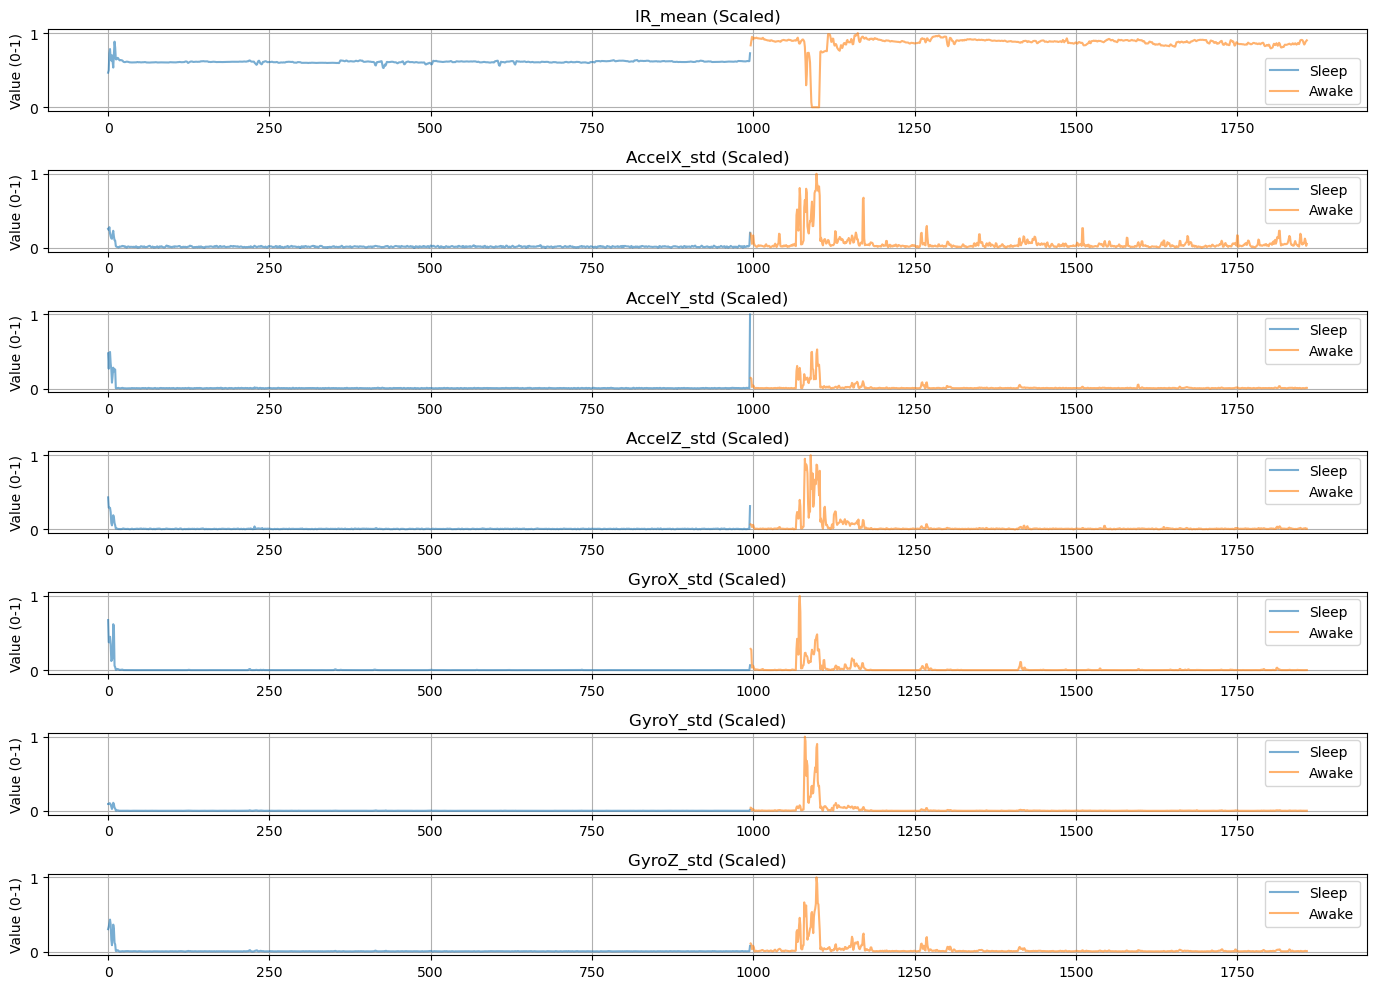

Model exported to svm_model.h and scaler_values.h


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("./aos_data/merged_phuc_data.csv")
features = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'IR']
raw_X = data[features]
y = data['Label'].map({'sleep': 0, 'awake': 1})

# Check class balance
if len(np.unique(y)) < 2:
    raise ValueError("Data contains only one class!")

# Sliding window parameters
window_size = 50  # ~5 seconds at 10 Hz
step_size = 25    # 50% overlap

# Feature extraction function
def extract_features(window):
    return np.concatenate([
        [window['IR'].mean()],           # Wrap scalar in list to make it 1D
        window[['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']].std().values  # Already 1D
    ])

# Create windowed dataset
X_windowed = []
y_windowed = []
for start in range(0, len(raw_X) - window_size + 1, step_size):
    window = raw_X.iloc[start:start + window_size]
    label = y.iloc[start:start + window_size].mode()[0]
    X_windowed.append(extract_features(window))
    y_windowed.append(label)

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
feature_names = ['IR_mean', 'AccelX_std', 'AccelY_std', 'AccelZ_std', 'GyroX_std', 'GyroY_std', 'GyroZ_std']

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_windowed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_windowed, test_size=0.2, random_state=42)

# Train SVM
model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")
print(f"Number of support vectors: {model.n_support_}")

# Check feature importance (coefficients for linear SVM)
coef = model.coef_[0]
for name, weight in zip(feature_names, coef):
    print(f"{name}: {weight:.4f}")

# Export scaler values
with open("scaler_values.h", "w") as f:
    f.write("// Scaler values\n")
    for i, name in enumerate(feature_names):
        f.write(f"const float {name}_min = {scaler.data_min_[i]}f;\n")
        f.write(f"const float {name}_max = {scaler.data_max_[i]}f;\n")

# Export SVM model
with open("svm_model.h", "w") as f:
    f.write("#ifndef SVM_MODEL_H\n")
    f.write("#define SVM_MODEL_H\n\n")
    f.write(f"const int n_features = {len(feature_names)};\n")
    f.write(f"const int n_support_vectors = {sum(model.n_support_)};\n\n")
    f.write("const float support_vectors[] = {\n")
    sv_flat = model.support_vectors_.flatten()
    for i, val in enumerate(sv_flat):
        f.write(f"{val}f")
        if i < len(sv_flat) - 1:
            f.write(", ")
        if (i + 1) % len(feature_names) == 0:
            f.write("\n")
    f.write("\n};\n\n")
    f.write("const float dual_coef[] = {\n")
    coef_flat = model.dual_coef_.flatten()
    for i, val in enumerate(coef_flat):
        f.write(f"{val}f")
        if i < len(coef_flat) - 1:
            f.write(", ")
        if (i + 1) % 10 == 0:
            f.write("\n")
    f.write("\n};\n\n")
    f.write(f"const float intercept = {model.intercept_[0]}f;\n")
    f.write("#endif\n")

# Plot scaled features for inspection
scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
scaled_df['Label'] = y_windowed
plt.figure(figsize=(14, 10))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(7, 1, i)
    for label in [0, 1]:
        subset = scaled_df[scaled_df['Label'] == label]
        plt.plot(subset.index, subset[feature], label='Awake' if label else 'Sleep', alpha=0.6)
    plt.title(f"{feature} (Scaled)")
    plt.ylabel("Value (0-1)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

print("Model exported to svm_model.h and scaler_values.h")